<a href="https://colab.research.google.com/github/SenseiBao/AI-Letter-Generator/blob/main/LetterGenerator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/FontGenerator # This directory should be where your fonts.zip dataset is located


Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/18rkU1fTZ1EbkkaMUzeKQzjMOYgfpWUws/FontGenerator


In [ ]:
# imports
import zipfile
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import os
import torch
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# extraction
with zipfile.ZipFile('fonts.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/unzipped_fonts')

# Check the extracted contents
os.listdir('/content/unzipped_fonts')


# Load a specific font data from an unzipped .npy file
#font_data = np.load('unzipped_fonts/font_A.npy')  # Adjust the path and filename




['character_fonts (with handwritten data).npz', 'Images', 'character_font.npz']

In [ ]:
# Path to dataset
dataset_path = '/content/unzipped_fonts/Images/Images'

# Image transformations
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Ensure grayscale
    transforms.Resize((32, 32)),                 # Resize to 32x32
    transforms.ToTensor(),                       # Convert images to tensors
    transforms.Normalize((0.5,), (0.5,))         # Normalize to [-1, 1]
])

# Load the dataset
dataset = datasets.ImageFolder(root=dataset_path, transform=transform)

# Create the DataLoader
batch_size = 128  # Smaller batch size for smaller images
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Check the dataset
print(f"Number of images in dataset: {len(dataset)}")



Number of images in dataset: 389765


In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(100 + 26, 256),  # Input latent vector + one-hot encoding
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 32 * 32),  # Output flattened image
            nn.Tanh()  # Normalize to [-1, 1]
        )

    def forward(self, noise, label):
        x = torch.cat((noise, label), dim=1)  # Concatenate noise and label
        x = self.model(x)
        x = x.view(-1, 1, 32, 32)  # Reshape to (batch_size, 1 channel, 32x32)
        return x


In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(32 * 32 + 26, 512),  # Flattened image + one-hot label
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 1),  # Output real/fake
            nn.Sigmoid()
        )

    def forward(self, img, label):
        img = img.view(img.size(0), -1)  # Flatten the image
        x = torch.cat((img, label), dim=1)  # Concatenate with label
        x = self.model(x)
        return x


In [ ]:

def one_hot_encode(labels, num_classes):
    """
    Convert labels to one-hot encoded vectors.
    Args:
        labels: A tensor of labels (integers).
        num_classes: The number of classes (e.g., 26 for the alphabet).
    Returns:
        One-hot encoded labels of shape (batch_size, num_classes).
    """
    return torch.nn.functional.one_hot(labels, num_classes=num_classes).float()


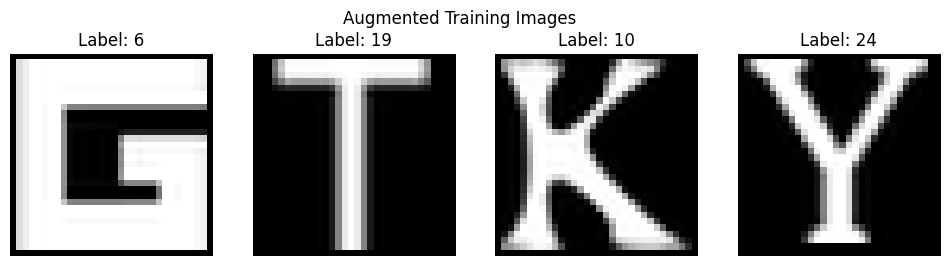

KeyboardInterrupt: 

In [ ]:
# Instantiate models
generator = Generator().cuda()
discriminator = Discriminator().cuda()

# Loss and optimizers
criterion = nn.BCELoss()
optimizer_G = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Training loop
num_epochs = 50

for epoch in range(num_epochs):
    for i, (real_images, labels) in enumerate(dataloader):
        real_images, labels = real_images.cuda(), labels.cuda()
        batch_size = real_images.size(0)

        # One-hot encode labels
        labels_one_hot = one_hot_encode(labels, num_classes=26).cuda()

        # On the first iteration, visualize the original and transformed images
        if i == 0:
            import matplotlib.pyplot as plt

            # Convert images back from [-1, 1] to [0, 1] for visualization
            real_images_vis = (real_images.cpu() * 0.5 + 0.5).clamp(0, 1)

            fig, axs = plt.subplots(1, 4, figsize=(12, 3))
            for idx in range(4):  # Display 4 samples for illustration
                axs[idx].imshow(real_images_vis[idx][0], cmap='gray')  # Only the first channel
                axs[idx].set_title(f"Label: {labels[idx].item()}")
                axs[idx].axis('off')
            plt.suptitle("Augmented Training Images")
            plt.show()

        # Train Discriminator
        optimizer_D.zero_grad()
        real_labels = torch.ones(batch_size, 1).cuda()
        fake_labels = torch.zeros(batch_size, 1).cuda()

        # Real images
        real_loss = criterion(discriminator(real_images, labels_one_hot), real_labels)

        # Fake images
        noise = torch.randn(batch_size, 100).cuda()
        fake_images = generator(noise, labels_one_hot)
        fake_loss = criterion(discriminator(fake_images.detach(), labels_one_hot), fake_labels)

        d_loss = real_loss + fake_loss
        d_loss.backward()
        optimizer_D.step()

        # Train Generator
        optimizer_G.zero_grad()
        g_loss = criterion(discriminator(fake_images, labels_one_hot), real_labels)
        g_loss.backward()
        optimizer_G.step()

    print(f"Epoch [{epoch+1}/{num_epochs}]  Loss D: {d_loss.item()}, Loss G: {g_loss.item()}")

    # Save model checkpoints
    torch.save(generator.state_dict(), f'generator_epoch_{epoch + 1}.pth')
    torch.save(discriminator.state_dict(), f'discriminator_epoch_{epoch + 1}.pth')




In [ ]:
# To load the model later
generator = Generator().cuda()
generator.load_state_dict(torch.load('/content/drive/MyDrive/FontGenerator/generator_epoch_50.pth'))
generator.eval()  # Switch to evaluation mode for inference

<ipython-input-22-5046c8593644>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator.load_state_dict(torch.load('/content/drive/MyDrive/FontGenerator/generator_epoch_5

Generator(
  (model): Sequential(
    (0): Linear(in_features=126, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=1024, bias=True)
    (5): ReLU()
    (6): Linear(in_features=1024, out_features=1024, bias=True)
    (7): Tanh()
  )
)

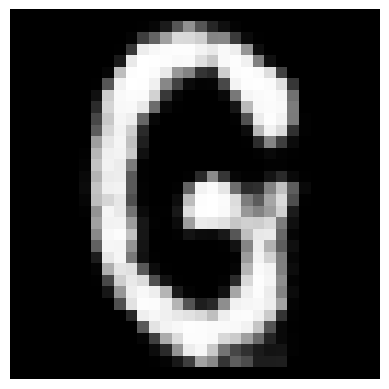

In [ ]:
def generate_specific_letter(letter):
    letter_idx = ord(letter.upper()) - ord('A')
    label = one_hot_encode(torch.tensor([letter_idx]), num_classes=26).cuda()
    noise = torch.randn(1, 100).cuda()
    generated_image = generator(noise, label)
    plt.imshow(generated_image.squeeze().cpu().detach().numpy(), cmap='gray')
    plt.axis('off')
    plt.show()


generate_specific_letter('G')

